In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from datafold.dynfold.dmd import ControlledLinearDynamicalSystem, DynamicalSystemBase, DMDBase, DMDControl, LinearDynamicalSystem
from datafold.pcfold import TSCDataFrame
import numpy as np
import numpy.testing as nptest
import pandas.testing as pdtest

from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from typing import Optional, List
import unittest
import warnings

### Implementatiom

In [3]:
class ControlledAffineDynamicalSystem(ControlledLinearDynamicalSystem):
    def __init__(self, time_invariant=True):
        super(ControlledAffineDynamicalSystem, self).__init__(time_invariant=time_invariant)
        self.sys_type = "differential"
        self._evolve_system_states_integer = self._evolve_system_states

    def _check_control_matrix(self, control_matrix):
        if control_matrix is None:
            control_matrix = self.control_matrix_
        else:
            if not isinstance(control_matrix, np.ndarray) or control_matrix.ndim != 3:
                raise ValueError("The control matrix tensor must be 3-dim. and of type np.ndarray")

            if control_matrix.shape[:2] != self.system_matrix_.shape:
                raise ValueError(
                    "control_matrix and system_matrix must have the same number of rows and columns"
                )
            self.control_matrix_ = control_matrix
        return control_matrix

    def setup_matrix_system(
        self,
        system_matrix: np.ndarray,
        control_matrix: np.ndarray,
    ):
        r"""Set up control affine system with system matrix and control matrix.

        Parameters
        ----------
        system_matrix
            The system matrix :math:`A` in differential representation

        control_matrix
            The control tensor :math:`B`

        Returns
        -------
        ControlledLinearDynamicalSystem
            self
        """
        self._check_matrix(system_matrix)
        if not isinstance(control_matrix, np.ndarray) or control_matrix.ndim != 3:
            raise ValueError("The control matrix tensor must be 3-dim. and of type np.ndarray")

        if control_matrix.shape[:2] != system_matrix.shape:
            raise ValueError(
                "control_matrix and system_matrix must have the same number of rows and columns"
            )
        self.sys_matrix_ = system_matrix
        self.control_matrix_ = control_matrix
        return self

    def _evolve_system_states(
        self,
        time_series_tensor: np.ndarray,
        sys_matrix: np.ndarray,
        control_matrix: np.ndarray,
        initial_conditions: np.ndarray,
        control_input: np.ndarray,
        time_values: np.ndarray,
        time_delta: Optional[float] = None,
    ) -> np.ndarray:
        
        interp_control = interp1d(time_values, control_input[0], axis=0)
        
        affine_system_func = lambda t, state: (
            sys_matrix @ state + control_matrix @ interp_control(t) @ state
        )
        
        ivp_solution = solve_ivp(
            affine_system_func,
            t_span=(time_values[0], time_values[-1]),
            y0=initial_conditions.flatten(),
            t_eval = time_values)
        
        if not ivp_solution.success:
            raise RuntimeError("The system could not be envolved for the requested timespan.")

        time_series_tensor[:] = ivp_solution.y.T

        return time_series_tensor

In [147]:
class DMDAffine(ControlledAffineDynamicalSystem, DMDControl):
    def __init__(
        self,
        *,  # keyword-only
        rcond: Optional[float] = None,
        state_columns: Optional[List[str]] = None,
        control_columns: Optional[List[str]] = None,
    ):
        self.rcond = rcond
        if state_columns is not None and control_columns is not None:
            self.state_columns = state_columns
            self.control_columns = control_columns
        super(DMDAffine, self).__init__(time_invariant=True)
        
    def _compute_koompan_matrices(
        self,
        state: TSCDataFrame,
        control_inp: TSCDataFrame,
    ):
        # TODO: add options to configure derivative
        Xdot_tsc = state.tsc.time_derivative()
        # trim samples where derivative is unknown
        X = state.select_time_values(Xdot_tsc.time_values()).values
        U = control_inp.select_time_values(Xdot_tsc.time_values()).values
        Xdot = Xdot_tsc.values

        n_snapshots = X.shape[0]
        state_cols = X.shape[1]
        control_cols = U.shape[1]
        if state_cols > n_snapshots:
            warnings.warn(
                "There are more observables than snapshots. The current implementation "
                "favors more snapshots than obserables. This may result in a bad "
                "computational performance."
            )
        
        # columnwise kronecker product
        u_x_cwise_kron = np.einsum('ij,ik->ijk',U,X).reshape(n_snapshots,control_cols*state_cols)

        # match naming convention from Peitz 2020
        Psi_XU = np.vstack([X.T, u_x_cwise_kron.T])
        Psidot_XU = Xdot.T
        #print("PsiXU")
        #print(Psi_XU)
        #print(np.linalg.cond(Psi_XU))
        #print("PsidotXU")
        #print(Psidot_XU)
        #print(np.linalg.cond(Psidot_XU))
        Mu = Psidot_XU @ np.linalg.pinv(Psi_XU)
        MuT = Mu.T
        #print(MuT)
        # Solve via normal equations
        G = Psi_XU @ Psi_XU.T
        np.multiply(1 / n_snapshots, G, out=G)  # improve condition?
        V = Psidot_XU @ Psi_XU.T
        np.multiply(1 / n_snapshots, V, out=V)  # improve condition?

        #V = Mu @ G => V.T = G.T @ Mu.T
        MuT, residual, rank, _ = np.linalg.lstsq(G.T, V.T, rcond=self.rcond)
        #print('next')
        #print(MuT)
        if rank != G.shape[1]:
            warnings.warn(
                f"Shift matrix (shape={G.shape}) has not full rank (={rank}), falling "
                f"back to least squares solution. The sum of residuals is: "
                f"{np.sum(residual)}"
            )
        
        sys_matrix = MuT.conj().T[:, :state_cols]
        control_matrix = MuT.conj().T[:, state_cols:]

        # reshape the matrix to a tensor
        control_tensor = control_matrix.reshape(state_cols,control_cols,state_cols).swapaxes(1,2).swapaxes(0,1)
        #print(sys_matrix.shape, control_tensor.shape)
        return sys_matrix, control_tensor

### Unit tests

In [5]:
class ControlledAffineDynamicalSystemTest(unittest.TestCase):
    def setUp(self) -> None:
        gen = np.random.default_rng(42)
        self.state_size = 4
        self.input_size = 2
        self.n_timesteps = 6
        self.A = gen.uniform(-1.0, 1.0, size=(self.state_size, self.state_size))
        self.x0 = gen.uniform(-1.0, 1.0, size=self.state_size)
        Bi = [gen.uniform(-1.0, 1.0, size=(self.state_size, self.state_size)) for i in range(self.input_size)]
        self.u = gen.uniform(-1.0, 1.0, size=(self.n_timesteps, self.input_size))
        self.t = np.linspace(0, self.n_timesteps - 1, self.n_timesteps)
        self.names = ["x" + str(i + 1) for i in range(self.state_size)]
        u_interp = interp1d(self.t, self.u, axis=0)
        
        def affine_sys_func(t, x):
            u = u_interp(t)
            B = np.zeros((self.state_size, self.state_size))
            for i in range(self.input_size):
                B += Bi[i] * u[i]
            x = self.A @ x + B @ x
            return x

        ivp_solution = solve_ivp(
            affine_sys_func,
            t_span=(self.t[0], self.t[-1]),
            y0=self.x0,
            t_eval = self.t)
        self.expected = ivp_solution.y.T
        self.Bi = np.stack(Bi, 2)


    def test_affine_system(self):
        actual = (
            ControlledAffineDynamicalSystem()
            .setup_matrix_system(self.A, self.Bi)
            .evolve_system(self.x0, self.u)
        )

        nptest.assert_allclose(actual.to_numpy(), self.expected, atol=1e-8, rtol=1e-13)

    def test_affine_vs_linear(self):
        
        controlled = (
            ControlledAffineDynamicalSystem()
            .setup_matrix_system(self.A, self.Bi)
            .evolve_system(self.x0, np.zeros(self.u.shape))
        )
        linear = (
            LinearDynamicalSystem(sys_type="differential", sys_mode="matrix")
            .setup_matrix_system(self.A)
            .evolve_system(self.x0, self.t, time_delta=self.t[1])
        )

        # use high tolerance since RK numerical integration compared to matrix exponent
        nptest.assert_allclose(
            controlled.to_numpy(), linear.to_numpy(), rtol=0.01
        )

In [9]:
class DMDAffineTest(unittest.TestCase):
    def  _create_control_tsc(self, state_size, input_size, n_timesteps):
        gen = np.random.default_rng(42)

        A = gen.uniform(-1.0, 1.0, size=(state_size, state_size))-np.diag(np.ones(state_size))
        x0 = gen.uniform(-1.0, 1.0, size=state_size)
        Bi = np.stack([gen.uniform(-1.0, 1.0, size=(state_size, state_size))-np.diag(np.ones(state_size)) for i in range(input_size)],2)
        u = gen.uniform(-1.0, 1.0, size=(n_timesteps, input_size))
        #u = np.repeat(gen.uniform(-1.0, 1.0, size=(1,input_size)),n_timesteps,axis=0) 
        #u = np.zeros((n_timesteps, input_size))
        t = np.linspace(0, n_timesteps - 1, n_timesteps)*0.1
        names = ["x" + str(i + 1) for i in range(state_size)]

        tsc_df = (
            ControlledAffineDynamicalSystem()
            .setup_matrix_system(A, Bi)
            .evolve_system(x0, u, time_values = t, time_delta = 0.1, feature_names_out=names)
        )
        #print(tsc_df)
        #print(A)
        #print(Bi)
        for i in range(input_size):
            tsc_df["u" + str(i + 1)] = u[:, i]

        return tsc_df
    
    def  _create_control_free_tsc(self, state_size, input_size, n_timesteps):
        gen = np.random.default_rng(42)

        A = gen.uniform(-1.0, 1.0, size=(state_size, state_size))-np.diag(np.ones(state_size))
        x0 = gen.uniform(-1.0, 1.0, size=state_size)
        Bi = np.stack([gen.uniform(-1.0, 1.0, size=(state_size, state_size))-np.diag(np.ones(state_size)) for i in range(input_size)],2)
        u = np.zeros((n_timesteps, input_size))
        t = np.linspace(0, n_timesteps - 1, n_timesteps)*0.1
        names = ["x" + str(i + 1) for i in range(state_size)]

        tsc_df = (
            ControlledAffineDynamicalSystem()
            .setup_matrix_system(A, Bi)
            .evolve_system(x0, u, time_values = t, time_delta = 0.1, feature_names_out=names)
        )
        #print(tsc_df)
        #print(A)
        #print(Bi)
        for i in range(input_size):
            tsc_df["u" + str(i + 1)] = u[:, i]

        return tsc_df

    def test_dmda_free(self):
        state_size = 4
        input_size = 2
        n_timesteps = 50
        n_predict = 5

        tsc_df = self._create_control_free_tsc(state_size, input_size, n_timesteps)

        state_cols = [f"x{i+1}" for i in range(state_size)]
        input_cols = [f"u{i+1}" for i in range(input_size)]
        dmd = DMDAffine(state_columns=state_cols, control_columns=input_cols).fit(
            tsc_df.iloc[:-n_predict]
        )

        u = tsc_df[input_cols].iloc[-n_predict:]
        t = tsc_df.index.get_level_values(1)[-n_predict:]
        expected = tsc_df[state_cols].iloc[-n_predict:]
        actual = dmd.predict(expected.initial_states(), control_input=u, time_values=t)

        pdtest.assert_frame_equal(actual, expected, rtol=1e-3)

    def test_dmda_control(self):
        state_size = 4
        input_size = 2
        n_timesteps = 50
        n_predict = 5

        tsc_df = self._create_control_tsc(state_size, input_size, n_timesteps)

        state_cols = [f"x{i+1}" for i in range(state_size)]
        input_cols = [f"u{i+1}" for i in range(input_size)]
        dmd = DMDAffine(state_columns=state_cols, control_columns=input_cols).fit(
            tsc_df.iloc[:-n_predict]
        )

        u = tsc_df[input_cols].iloc[-n_predict:]
        t = tsc_df.index.get_level_values(1)[-n_predict:]
        expected = tsc_df[state_cols].iloc[-n_predict:]
        actual = dmd.predict(expected.initial_states(), control_input=u, time_values=t)

        pdtest.assert_frame_equal(actual, expected)


unittest.main(argv=[''], verbosity=2, exit=False)

test_affine_system (__main__.ControlledAffineDynamicalSystemTest) ... ok
test_affine_vs_linear (__main__.ControlledAffineDynamicalSystemTest) ... ok
test_dmda_control (__main__.DMDAffineTest) ... FAIL
test_dmda_free (__main__.DMDAffineTest) ... C:\Users\etodorov\AppData\Local\Temp/ipykernel_14608/1999665609.py:59: UserWarning: Shift matrix (shape=(12, 12)) has not full rank (=4), falling back to least squares solution. The sum of residuals is: 0.0
  warnings.warn(
ok

FAIL: test_dmda_control (__main__.DMDAffineTest)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "C:\Users\etodorov\AppData\Local\Temp/ipykernel_14608/3005077945.py", line 90, in test_dmda_control
    pdtest.assert_frame_equal(actual, expected)
  File "C:\Users\etodorov\anaconda3\envs\.venv\lib\site-packages\pandas\_testing.py", line 1704, in assert_frame_equal
    assert_series_equal(
  File "C:\Users\etodorov\anaconda3\envs\.venv\lib\site-packages\pandas\_

In [45]:
from datafold.appfold import EDMDControl
from datafold.dynfold.transform import TSCIdentity, TSCRadialBasis, TSCPolynomialFeatures
from datafold.utils._systems import InvertedPendulum
from datafold.pcfold import InitialCondition, InverseQuadraticKernel
import pandas as pd
import matplotlib.pyplot as plt

### Duffing

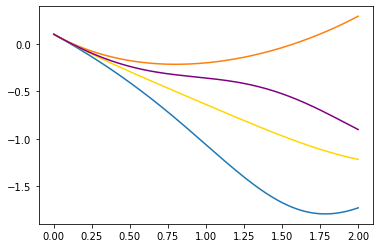

In [57]:
def duffing(t, x, alpha=-1, beta=1, delta=0.6, u=lambda t: 1):
    xdot = np.array([x[1],0])
    xdot[1] = -delta*x[1] - alpha*x[0] - beta*x[0]**3+u(t)
    return xdot

def simulate(x0, u=lambda t: 1, N=201, t0=0, tf = 2):
    sol = solve_ivp(lambda t,x: duffing(t,x,u=u),(t0,tf),x0,t_eval=np.linspace(t0,tf,N))
    if not sol.success:
        raise RuntimeError("Couldn't not evolve the system.")
    df = pd.DataFrame(data=sol.y.T, index=sol.t, columns=['x','xdot'])
    df['u'] = u(sol.t)
    return df

x0 = np.array([0.1,-0.9])
x = simulate(x0, lambda t: -1)
plt.plot(x['x'])
x = simulate(x0)
plt.plot(x['x'])
x = simulate(x0, lambda t: np.sin(np.pi*t))
plt.plot(x['x'],'purple')
x = simulate(x0, lambda t: 0)
plt.plot(x['x'],'gold')

<AxesSubplot:xlabel='time'>

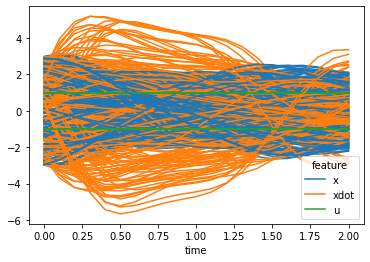

In [154]:
n_repeats = 100
rng = np.random.default_rng(0)
dflist = []
for i in range(n_repeats):
    random_x0 = rng.uniform(-3,3,2)
    dflist.append(simulate(random_x0,N=21))
    dflist.append(simulate(random_x0, lambda t: -1, N=21))
duffing_tsc = TSCDataFrame.from_frame_list(dflist)
duffing_tsc.plot()

In [155]:
edmd_duffing = EDMDControl(dict_steps=[("poly", TSCPolynomialFeatures(5)),])
edmd_duffing._dmd_model = DMDAffine(rcond=1e-6)
edmd_duffing.include_id_state = None
edmd_duffing.fit(duffing_tsc, split_by='name', control=['u'])


EDMDControl(dict_steps=[('poly', TSCPolynomialFeatures(degree=5))],
            include_id_state=None)

Sys eigenvalues:  [-0.54099977+5.28915495j -0.54099977-5.28915495j -0.50262799+3.13829289j
 -0.50262799-3.13829289j -0.92836891+2.05021312j -0.92836891-2.05021312j
 -0.09976322+0.86079649j -0.09976322-0.86079649j -0.60660412+0.j        ]
Control eigenvalues:  [ 6.82255020e-01+0.j         -4.14747536e-01+0.13327751j
 -4.14747536e-01-0.13327751j  1.28239807e-01+0.26607991j
  1.28239807e-01-0.26607991j  1.44445041e-02+0.05190783j
  1.44445041e-02-0.05190783j  5.64428862e-05+0.j
 -1.26530873e-02+0.j        ]


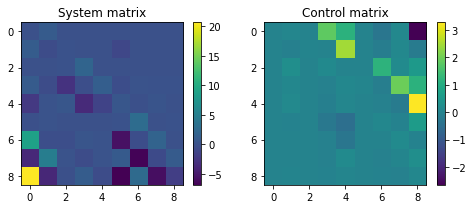

In [149]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.imshow(edmd_duffing.sys_matrix)
plt.colorbar()
plt.title("System matrix")
print("Sys eigenvalues: ", np.linalg.eigvals(edmd_duffing.sys_matrix))
plt.subplot(122)
plt.imshow(edmd_duffing.control_matrix[:,:,0])
plt.colorbar()
plt.title("Control matrix")
print("Control eigenvalues: ", np.linalg.eigvals(edmd_duffing.control_matrix[:,:,0]))



In [156]:
out = np.zeros((9,101))
out[:,0] = edmd_duffing.transform(InitialCondition.from_array(x0,columns=['x','xdot'])).values.ravel()
for i in range(100):
    xdot = (edmd_duffing.sys_matrix @ out[:,i] + edmd_duffing.control_matrix[:,:,0] @ out[:,i]).ravel()
    out[:,i+1] = out[:,i] + 0.01*xdot
plt.plot(out[0])

ValueError: could not broadcast input array from shape (20,) into shape (9,)

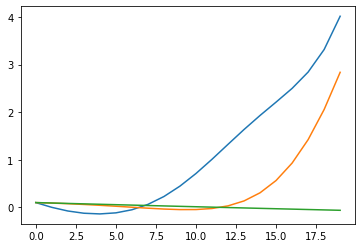

In [164]:
pred0 = edmd_duffing.predict(InitialCondition.from_array(x0,columns=['x','xdot']),time_values=np.linspace(0,1,101),control_input=np.ones(101))
plt.plot(pred0['x'].values[:20])
pred0 = edmd_duffing.predict(InitialCondition.from_array(x0,columns=['x','xdot']),time_values=np.linspace(0,1,101),control_input=-np.ones(101))
#plt.plot(pred0['x'].values[:20])
pred0 = edmd_duffing.predict(InitialCondition.from_array(x0,columns=['x','xdot']),time_values=np.linspace(0,1,101),control_input=np.sin(np.pi*np.linspace(0,1,101)))
plt.plot(pred0['x'].values[:20])
pred0 = edmd_duffing.predict(InitialCondition.from_array(x0,columns=['x','xdot']),time_values=np.linspace(0,1,101),control_input=0*np.ones(101))
plt.plot(pred0['x'].values[:20])

In [144]:
simulate(x0)

,x,xdot,u
0.00,0.100000,-0.900000,1
0.01,0.091082,-0.883702,1
0.02,0.082325,-0.867588,1
0.03,0.073729,-0.851655,1
0.04,0.065292,-0.835901,1
...,...,...,...
1.96,0.256435,0.811656,1
1.97,0.264589,0.819191,1
1.98,0.272818,0.826746,1
1.99,0.281124,0.834319,1


### Inverted Pendulum

In [14]:
state_cols = ["x", "xdot", "theta", "thetadot"]
control_cols = ["u"]

# Data generation parameters
sim_time_step = 0.01  # s
sim_num_steps = 1000  # -
training_size = 20  # -
ic = InitialCondition.from_array(np.array([0, 0, np.pi, 0]), columns=state_cols)

invertedPendulum = InvertedPendulum(initial_condition=ic.values)

Xlist, Ulist = [], []
np.random.seed(42)
for i in range(training_size):
    control_amplitude = 0.1 + 0.9 * np.random.random()
    control_frequency = np.pi + 2 * np.pi * np.random.random()
    control_phase = 2 * np.pi * np.random.random()
    control_func = lambda t, y: control_amplitude * np.sin(
        control_frequency * t + control_phase
    )
    invertedPendulum.reset()
    traj = invertedPendulum.predict(
        time_step=sim_time_step,
        num_steps=sim_num_steps,
        control_func=control_func,
    )
    assert (
        invertedPendulum.sol.success
    ), f"Divergent solution for amplitude={control_amplitude}, frequency={control_frequency}"
    t = invertedPendulum.sol.t
    dfx = pd.DataFrame(data=traj.T, index=t, columns=state_cols)
    dfx[control_cols] = 0.0
    Xlist.append(dfx)
    control_input = control_func(t, traj)
    dfu = pd.DataFrame(data=control_input, index=t, columns=control_cols)
    for col in state_cols:
        dfu[col] = 0.0
    dfu = dfu[state_cols + control_cols]
    Ulist.append(dfu)

X_tsc = TSCDataFrame.from_frame_list(Xlist)[state_cols]
X_tsc[control_cols] = TSCDataFrame.from_frame_list(Ulist)[control_cols]

In [30]:
num_rbfs = 20
eps = 1

rbf = TSCRadialBasis(
    kernel=InverseQuadraticKernel(epsilon=eps), center_type="fit_params"
)
center_ids = sorted(
    np.random.choice(
        range(0, sim_num_steps * training_size), size=num_rbfs, replace=False
    )
)
centers = X_tsc.iloc[center_ids].values

In [67]:
edmdrbf = EDMDControl(dict_steps=[("rbf", rbf),], include_id_state=True)

edmdrbf._dmd_model = DMDAffine(rcond=1e-6)

edmdrbf.fit(
    X_tsc,
    split_by="name",
    state=state_cols,
    control=control_cols,
    rbf__centers=centers[:, :-1],
)
rbfprediction = edmdrbf.predict(
    ic, control_input=np.atleast_2d(control_input).T, time_values=t
)
plt.figure(figsize=(16, 3))
plt.subplot(121)
plt.plot(rbfprediction["x"].values, label="prediction")
plt.plot(dfx["x"].values, label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - cart position $x$")
plt.subplot(122)
plt.plot(rbfprediction["theta"].values, label="prediction")
plt.plot(dfx["theta"].values, label="actual")
plt.legend()
plt.title(r"EDMD(100 random rbf) prediction - pendulum angle $\theta$");


C:\Users\etodorov\AppData\Local\Temp/ipykernel_9960/134538018.py:67: RuntimeWarning: invalid value encountered in matmul
  sys_matrix @ state + control_matrix @ interp_control(t) @ state
C:\Users\etodorov\AppData\Local\Temp/ipykernel_9960/134538018.py:67: RuntimeWarning: invalid value encountered in add
  sys_matrix @ state + control_matrix @ interp_control(t) @ state


RuntimeError: The system could not be envolved for the requested timespan.

In [58]:
edmdrbf.predict(ic, control_input=np.atleast_2d(control_input[:10]).T, time_values=t[:10])

feature          x        xdot      theta     thetadot
ID time                                               
0  0.00   0.000000    0.000000   3.141593     0.000000
   0.01  -0.008822    0.062232   3.142834     0.374772
   0.02  -0.031936    0.277852   3.153393     1.691552
   0.03  -0.086075    0.749968   3.188454     4.980371
   0.04  -0.207312    1.847492   3.287846    14.047354
   0.05  -0.503320    4.646489   3.570967    40.337293
   0.06  -1.279709   12.091678   4.382546   115.605498
   0.07  -3.356321   32.150751   6.683669   326.410447
   0.08  -8.875820   86.175170  13.096786   906.001577
   0.09 -23.344145  230.529850  30.652417  2473.132575

In [68]:
np.linalg.eigvals(edmdrbf.sys_matrix), np.linalg.eigvals(edmdrbf.control_matrix.squeeze())

(array([13.86943087 +0.j        ,  0.11624173+18.2616053j ,
         0.11624173-18.2616053j , -0.76560449+16.67115706j,
        -0.76560449-16.67115706j, -0.26597487+12.27095743j,
        -0.26597487-12.27095743j,  0.09235092+10.95108097j,
         0.09235092-10.95108097j, -0.16169686 +6.86567671j,
        -0.16169686 -6.86567671j, -1.03860128 +4.19903431j,
        -1.03860128 -4.19903431j, -4.30923405 +2.75053239j,
        -4.30923405 -2.75053239j, -4.87100305 +0.j        ,
        -4.28388089 +0.j        , -0.80077549 +1.67048143j,
        -0.80077549 -1.67048143j,  0.04892849 +0.33494963j,
         0.04892849 -0.33494963j,  0.1206007  +0.j        ,
        -0.89921996 +0.j        , -1.49113064 +0.j        ]),
 array([ 3.03150897e+00+30.34907652j,  3.03150897e+00-30.34907652j,
         2.15732574e+00+25.5076632j ,  2.15732574e+00-25.5076632j ,
         2.27322198e+01 +0.j        , -3.11704659e+00+19.70502968j,
        -3.11704659e+00-19.70502968j,  1.73148829e+00+13.43652094j,
      

### Einsum test

In [60]:
np.einsum('ij,ik->ijk',np.array([[1,-1],
                                 [2,-2],
                                 [3,-3]]),
                       np.array([[0.1,0.2,0.3,0.4],
                                 [1.1,1.2,1.3,1.4],
                                 [10.1,12.1,13.1,14.1]])).reshape(3,2*4)

array([[  0.1,   0.2,   0.3,   0.4,  -0.1,  -0.2,  -0.3,  -0.4],
       [  2.2,   2.4,   2.6,   2.8,  -2.2,  -2.4,  -2.6,  -2.8],
       [ 30.3,  36.3,  39.3,  42.3, -30.3, -36.3, -39.3, -42.3]])

In [61]:
np.einsum('ij,ik->ijk',np.array([[0.1,0.2,0.3,0.4],
                                 [1.1,1.2,1.3,1.4],
                                 [10.1,12.1,13.1,14.1]]),
                       np.array([[1,-1],
                                 [2,-2],
                                 [3,-3]])
                       ).reshape(3,2*4)

array([[  0.1,  -0.1,   0.2,  -0.2,   0.3,  -0.3,   0.4,  -0.4],
       [  2.2,  -2.2,   2.4,  -2.4,   2.6,  -2.6,   2.8,  -2.8],
       [ 30.3, -30.3,  36.3, -36.3,  39.3, -39.3,  42.3, -42.3]])

In [ ]:
X_tsc